# Import library

In [128]:
import copy
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn import metrics
import pickle
import lightgbm as lgb
import category_encoders as ce

# Load data

In [69]:
df = pd.read_csv('../crawler/data_bonbanh.csv')

# Data overview

In [70]:
def describle_data():
    print('Shape of data:\n', df.shape)
    print('--'*20)
    print('Columns of data: \n', df.columns)
    print('--'*20)
    print('Data types of data: \n', df.dtypes)
    print('--'*20)
    print('Missing values of data: \n', df.isna().sum())
    print('--'*20)
    print('Describe data: \n', df.describe())
    print('--'*20)
    print('Info data: \n', df.info())
describle_data()

Shape of data:
 (14212, 9)
----------------------------------------
Columns of data: 
 Index(['car_name', 'year', 'price', 'assemble_place', 'series', 'km',
       'engine_type', 'transmission', 'url'],
      dtype='object')
----------------------------------------
Data types of data: 
 car_name          object
year              object
price             object
assemble_place    object
series            object
km                object
engine_type       object
transmission      object
url               object
dtype: object
----------------------------------------
Missing values of data: 
 car_name          1
year              0
price             0
assemble_place    0
series            0
km                0
engine_type       0
transmission      0
url               0
dtype: int64
----------------------------------------
Describe data: 
                             car_name   year      price      assemble_place  \
count                          14211  14212      14212               14212   

# Xóa bỏ những xe bị trùng lặp

In [71]:
df.drop_duplicates(subset=['url'], inplace=True)
describle_data()

Shape of data:
 (14188, 9)
----------------------------------------
Columns of data: 
 Index(['car_name', 'year', 'price', 'assemble_place', 'series', 'km',
       'engine_type', 'transmission', 'url'],
      dtype='object')
----------------------------------------
Data types of data: 
 car_name          object
year              object
price             object
assemble_place    object
series            object
km                object
engine_type       object
transmission      object
url               object
dtype: object
----------------------------------------
Missing values of data: 
 car_name          1
year              0
price             0
assemble_place    0
series            0
km                0
engine_type       0
transmission      0
url               0
dtype: int64
----------------------------------------
Describe data: 
                             car_name   year      price      assemble_place  \
count                          14187  14188      14188               14188   

# Chuyển đổi kiểu dữ liệu cho các cột year, price sang kiểu số thực để có thể thực hiện các phép tính toán

Year

In [72]:
def process_year_colum(year):
    if year.isdigit():
        return float(year)
    else:
        return 0
df['year'] = df['year'].astype(str).apply(process_year_colum)
describle_data()

Shape of data:
 (14188, 9)
----------------------------------------
Columns of data: 
 Index(['car_name', 'year', 'price', 'assemble_place', 'series', 'km',
       'engine_type', 'transmission', 'url'],
      dtype='object')
----------------------------------------
Data types of data: 
 car_name           object
year              float64
price              object
assemble_place     object
series             object
km                 object
engine_type        object
transmission       object
url                object
dtype: object
----------------------------------------
Missing values of data: 
 car_name          1
year              0
price             0
assemble_place    0
series            0
km                0
engine_type       0
transmission      0
url               0
dtype: int64
----------------------------------------
Describe data: 
                year
count  14188.000000
mean    1991.748802
std      228.799373
min        0.000000
25%     2016.000000
50%     2019.000000
75%   

Price

In [73]:
df.isna().sum()
df.dropna(subset=['car_name'], inplace=True)

In [74]:
def process_price(price):
    try:
        if price.find('Tỷ') != -1:
            ty= price.split('Tỷ')[0]
            trieu = price.split('Tỷ')[1]
            trieu = trieu.split('Triệu')[0]
            return float(ty)*1000000000 + float(trieu)*1000000
        elif price.find('Triệu') != -1:
            trieu = price.split('Triệu')[0]
            trieu = trieu.replace(' ','')
            return float(trieu)*1000000
        else:
            return 0
    except:
        return 0
df['price'] = df['price'].astype(str).apply(process_price)

In [75]:
# Remove 'Km' and commas from the 'km' column
df['km'] = df['km'].str.replace('Km', '').str.replace(',', '')

# Convert the 'km' column to numeric
df['km'] = pd.to_numeric(df['km'])


In [76]:
df['km'].describe()
# lấy ra các xe có số km đi được nhỏ hơn 1000km
print(df[df['km'] < 1000]['url'])

1        https://bonbanh.com/xe-maserati-levante-s-gran...
3        https://bonbanh.com/xe-toyota-land_cruiser-5.7...
5        https://bonbanh.com/xe-ford-focus-titanium-2.0...
8        https://bonbanh.com/xe-landrover-range_rover-a...
10       https://bonbanh.com/xe-chevrolet-captiva-lt-2....
                               ...                        
14162    https://bonbanh.com/xe-toyota-venza-2.7-2009-5...
14172    https://bonbanh.com/xe-kia-sedona-3.3-gat-prem...
14178    https://bonbanh.com/xe-toyota-corolla_cross-1....
14190    https://bonbanh.com/xe-mazda-cx5-2.0-luxury-20...
14205    https://bonbanh.com/xe-mercedes_benz-glc-300-4...
Name: url, Length: 1796, dtype: object


In [136]:
#drop all rows with driven kms < 1000, nan values in all columns
df.drop(df[df['km'] < 1000].index, inplace=True)
df.dropna(inplace=True)
df.isna().sum()

year                            0.0
price                           0.0
assemble_place                  0.0
km                              0.0
transmission                    0.0
brand                           0.0
series_Bán tải / Pickup       0.0
series_Convertible/Cabriolet    0.0
series_Coupe                    0.0
series_Crossover                0.0
series_Hatchback                0.0
series_SUV                      0.0
series_Sedan                    0.0
series_Truck                    0.0
series_Van/Minivan              0.0
engine_type_Dầu                 0.0
engine_type_Hybrid              0.0
engine_type_Xăng                0.0
engine_type_Điện                0.0
dtype: float64

In [137]:
df['price'].describe()


count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: price, dtype: float64

In [79]:
#loại bỏ các xe có giá trị price = 0
df.drop(df[df['price'] == 0].index, inplace=True)
df['price'].describe()

count    1.219500e+04
mean     1.160486e+09
std      1.639408e+09
min      2.600000e+07
25%      4.700000e+08
50%      6.660000e+08
75%      1.096500e+09
max      4.380000e+10
Name: price, dtype: float64

# Xử lý các cột dạng nhãn

Car_name có hai phần là hãng xe và tên xe, ta sẽ tách ra thành hai cột là brand và model


In [80]:
df['brand'] = df['car_name'].str.split().str[0]
df['model'] = df['car_name'].str.split().str[1:].str.join(' ')

In [81]:
df['brand'].value_counts()

brand
Toyota         2425
Mercedes       1582
Hyundai        1359
Kia            1096
Ford           1053
Mazda          1001
Lexus           576
Mitsubishi      496
Honda           491
VinFast         448
BMW             261
Porsche         218
LandRover       202
Peugeot         146
Chevrolet       142
Suzuki          105
Audi            105
Nissan           97
MG               81
Volkswagen       39
Mini             33
Bentley          30
Daewoo           29
Rolls            27
Volvo            20
Jeep             16
Maserati         15
Cadillac         15
Infiniti         12
Isuzu            11
Jaguar           10
Ssangyong         7
Dongben           5
Maybach           5
Fiat              4
Ferrari           4
Renault           4
Subaru            3
Thaco             3
Lamborghini       2
Lincoln           2
Hino              2
Scion             2
RAM               2
Daihatsu          1
Baic              1
Chrysler          1
McLaren           1
Samsung           1
Dongfeng      

In [18]:
df.head()

,car_name,year,price,assemble_place,series,km,engine_type,transmission,url,brand,model
0,Kia Sorento Signature 2.2 AT AWD,2020.0,8.990000e+08,Lắp ráp trong nước,SUV,60000,Dầu 2.2 L,Số tự động,https://bonbanh.com/xe-kia-sorento-signature-2...,Kia,Sorento Signature 2.2 AT AWD
2,Kia Sorento GATH,2018.0,5.680000e+08,Lắp ráp trong nước,SUV,80000,Xăng 2.4 L,Số tự động,https://bonbanh.com/xe-kia-sorento-gath-2018-5...,Kia,Sorento GATH
4,Mazda CX8 Premium AWD,2022.0,9.290000e+08,Lắp ráp trong nước,SUV,50000,Xăng 2.5 L,Số tự động,https://bonbanh.com/xe-mazda-cx8-premium-awd-2...,Mazda,CX8 Premium AWD
6,Nissan Almera 1.0 MT,2022.0,3.690000e+08,Nhập khẩu,Sedan,25000,Xăng 1.0 L,Số tay,https://bonbanh.com/xe-nissan-almera-1.0-mt-20...,Nissan,Almera 1.0 MT
7,Bentley Mulsanne 6.75 V8,2011.0,4.900000e+09,Nhập khẩu,Sedan,80000,Xăng 6.8 L,Số tự động,https://bonbanh.com/xe-bentley-mulsanne-6.75-v...,Bentley,Mulsanne 6.75 V8


# Xử lý các dữ liệu bị thiếu hoặc sai


Xử lý cột year

In [82]:
car_before_1990 = df[df['year'] < 1990]
print('Number of car before 1990: ', car_before_1990.shape[0])
print('Number of car before 1990: ', car_before_1990['year'].value_counts())

Number of car before 1990:  0
Number of car before 1990:  Series([], Name: count, dtype: int64)


Điền các giá trị sai trong cột year bằng giá trị xuất hiện nhiều nhất trong cột year

In [83]:
df['year'] = df['year'].apply(lambda x: df['year'].value_counts().index[0] if x < 1990 else x)

Cột price: các giá trị bằng = 0 sẽ được thay thế bằng giá trung bình của các xe sản xuất trong năm đó

In [84]:
df['price'] = df['price'].apply(lambda x: df[df['year'] == x]['price'].mean() if x == 0 else x)
df['price'].describe()

count    1.219500e+04
mean     1.160486e+09
std      1.639408e+09
min      2.600000e+07
25%      4.700000e+08
50%      6.660000e+08
75%      1.096500e+09
max      4.380000e+10
Name: price, dtype: float64

Cột brand

In [85]:
df['brand'].value_counts()

brand
Toyota         2425
Mercedes       1582
Hyundai        1359
Kia            1096
Ford           1053
Mazda          1001
Lexus           576
Mitsubishi      496
Honda           491
VinFast         448
BMW             261
Porsche         218
LandRover       202
Peugeot         146
Chevrolet       142
Suzuki          105
Audi            105
Nissan           97
MG               81
Volkswagen       39
Mini             33
Bentley          30
Daewoo           29
Rolls            27
Volvo            20
Jeep             16
Maserati         15
Cadillac         15
Infiniti         12
Isuzu            11
Jaguar           10
Ssangyong         7
Dongben           5
Maybach           5
Fiat              4
Ferrari           4
Renault           4
Subaru            3
Thaco             3
Lamborghini       2
Lincoln           2
Hino              2
Scion             2
RAM               2
Daihatsu          1
Baic              1
Chrysler          1
McLaren           1
Samsung           1
Dongfeng      

Cột brand có một số hãng có số lượng xe rất ít hoặc bị thiếu, ta sẽ gộp các hãng xe này thành một nhóm là 'other'
Nếu số xe của hãng đó nhỏ hơn 10 thì sẽ gộp vào nhóm 'Other'

In [86]:
threshold = 10
car_count = df['brand'].value_counts()
small_brands = car_count[car_count < threshold].index.tolist()
df['brand'] = df['brand'].apply(lambda x: 'Other' if x in small_brands else x)
df['brand'].fillna('Other', inplace=True)

In [87]:
# in ra tất cả brand
# sắp xếp theo thứ tự giảm dần về giá trung bình
print(df.groupby('brand')['price'].mean().sort_values(ascending=False))


brand
Rolls         1.567563e+10
Bentley       5.436433e+09
Porsche       3.769440e+09
LandRover     3.488574e+09
Lexus         3.280689e+09
Maserati      3.246600e+09
Other         3.190852e+09
Cadillac      2.918267e+09
Volvo         2.740050e+09
Jeep          2.654688e+09
Mercedes      1.897352e+09
Jaguar        1.548800e+09
Mini          1.501061e+09
BMW           1.437004e+09
Audi          1.133371e+09
Infiniti      1.050250e+09
Toyota        8.939118e+08
Volkswagen    8.273846e+08
Peugeot       7.799247e+08
Ford          7.532536e+08
Hyundai       6.230787e+08
Mazda         6.160559e+08
Honda         5.976497e+08
Kia           5.950712e+08
VinFast       5.875848e+08
Mitsubishi    5.188448e+08
MG            4.642840e+08
Nissan        4.599278e+08
Isuzu         4.460909e+08
Suzuki        3.879619e+08
Chevrolet     3.207535e+08
Daewoo        1.451724e+08
Name: price, dtype: float64


In [25]:
# def car_band(x):
#     if x in ['Land', 'Lamborghini', 'Jaguar', 'BMW', 'Mercedes', 'Porsche','Jeep',
#        'Audi', 'Bentley','Mini','LandRover','Lexus','Maserati','Rolls','Ferrari','Aston','Lincoln','Maserati','Cadillac']:
#         return 'HIGH END CAR'    
#     elif x in ['Ford',
#             'Skoda',
#          'Mahindra',
#             'Force',
#        'Mitsubishi',
#            'Toyota',
#             'ISUZU',
#            'Volvo',
#           'Isuzu','Other']:
#         return 'MIDDLE RANGE CAR'
#     else:
#         return 'LOW END CAR'
# df['brand']=df['brand'].apply(car_band)
# def car_band(x):
#     if x in ['Rolls', 'Bentley', 'Ferrari','Lincoln','Porsche','LandRover','Lexus','Jeep']:
#         return 'LUXURY CAR'
#     elif x in ['Maserati', 'Cadillac', 'Lincoln', 'Mercedes', 'Audi', 'BMW', 'Volvo']:
#         return 'PREMIUM CAR'
#     elif x in ['VW', 'Seat', 'Ford', 'Opel','VinFast','Mazda','Honda','Hyundai','Kia','Chevrolet','Toyota','Suzuki','Nissan','Renault','Other']:
#         return 'VOLUME CAR'
#     else:
#         return 'LOW-PRICE CAR'
# def car_band(x):
#     if x in ['Rolls-Royce', 'Bentley', 'Lincoln', 'Land Rover', 'Porsche', 'Maserati', 'Lexus', 'Jeep', 'Cadillac']:
#         return 'LUXURY CAR'
#     elif x in ['Mini', 'BMW', 'Audi', 'Volvo', 'Mercedes-Benz', 'Infiniti', 'Jaguar','Other']:
#         return 'PREMIUM CAR'
#     elif x in ['Subaru', 'Volkswagen', 'Peugeot', 'Toyota', 'Ford', 'VinFast', 'Mazda', 'Hyundai', 'Honda']:
#         return 'VOLUME CAR'
#     else:
#         return 'LOW-PRICE CAR'
def car_band(x):
    if x in ['Rolls', 'Bentley', 'Lincoln', 'LandRover', 'Porsche', 'Maserati', 'Lexus', 'Jeep', 'Cadillac']:
        return 'LUXURY'
    elif x in ['Other', 'Volvo', 'Mercedes', 'Infiniti', 'Jaguar', 'Mini', 'BMW', 'Audi']:
        return 'PREMIUM'
    elif x in ['Subaru', 'Volkswagen', 'Peugeot', 'Toyota', 'Ford', 'VinFast', 'Mazda', 'Hyundai', 'Honda','MG','Mitsubishi']:
        return 'VOLUME'
    else:
        return 'LOWEND'

df['brand_segment'] = df['brand'].apply(car_band)
df.drop(columns=['brand'], inplace=True)
df['brand_segment'].value_counts()


brand_segment
VOLUME     7539
PREMIUM    2077
LOWEND     1480
LUXURY     1099
Name: count, dtype: int64

Cột series: ta thấy các giá trị của cột series có giá trị nan, ta sẽ điền các giá trị này bằng giá trị xuất hiện nhiều nhất trong cột series

In [88]:
df['series'] = df['series'].apply(lambda x: df['series'].value_counts().index[0] if x == '-' else x)
df['series'].fillna(df['series'].value_counts().index[0], inplace=True)

In [89]:
df['series'].isna().sum()

0

Cột engine_type: ta thấy có một vài giá trị bị thiếu, ta sẽ điền các giá trị này bằng giá trị xuất hiện nhiều nhất trong cột engine_type

In [90]:
df['engine_type'] = df['engine_type'].apply(lambda x: df['engine_type'].value_counts().index[0] if x == '-' else x)
df['engine_type'].fillna(df['engine_type'].value_counts().index[0], inplace=True)

In [91]:
df['engine_type'].isna().sum()

0

Cột transmission tương tự cột engine_type

In [92]:
df['transmission'] = df['transmission'].apply(lambda x: df['transmission'].value_counts().index[0] if x == '-' else x)
df['transmission'].fillna(df['transmission'].value_counts().index[0], inplace=True)

In [31]:
df['transmission'].isna().sum()

0

In [93]:
df['engine_type'] = df['engine_type'].str.split().str[0]#%% md


In [94]:
df['engine_type'].value_counts()

engine_type
Xăng      10264
Dầu        1724
Hybrid      131
Điện         76
Name: count, dtype: int64

Tìm hiểu về mối liên hệ giữa giá xe và các thuộc tính khác

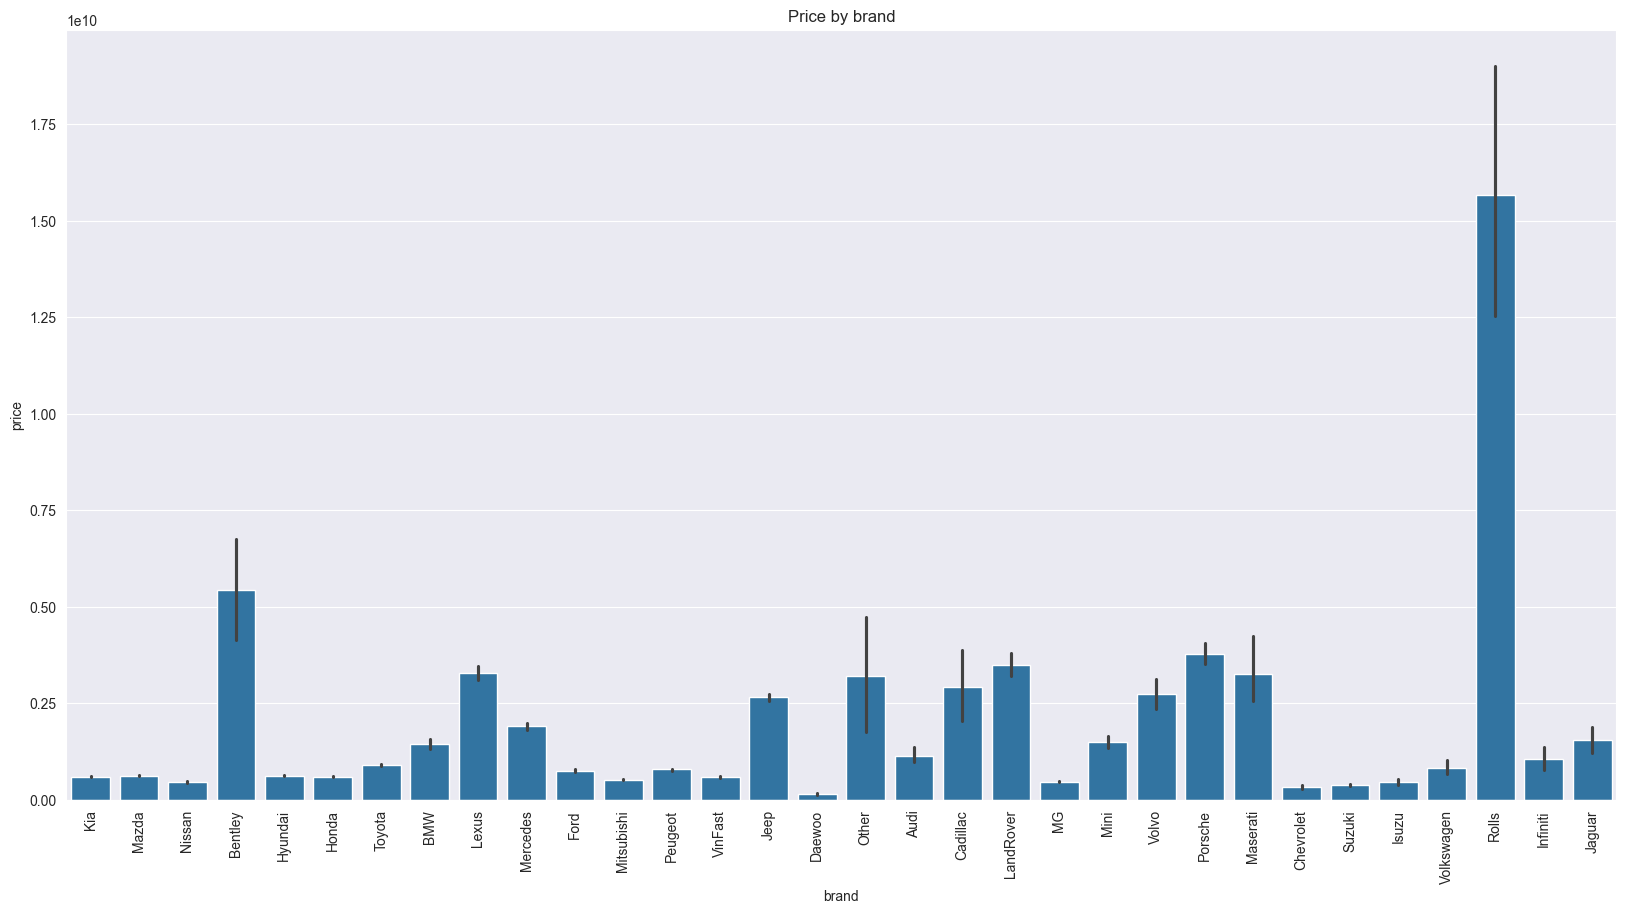

In [97]:
#vẽ price theo brand, series,year
plt.figure(figsize=(20, 10))
sns.barplot(x='brand', y='price', data=df)
plt.title('Price by brand')
plt.xticks(rotation=90)
plt.show()

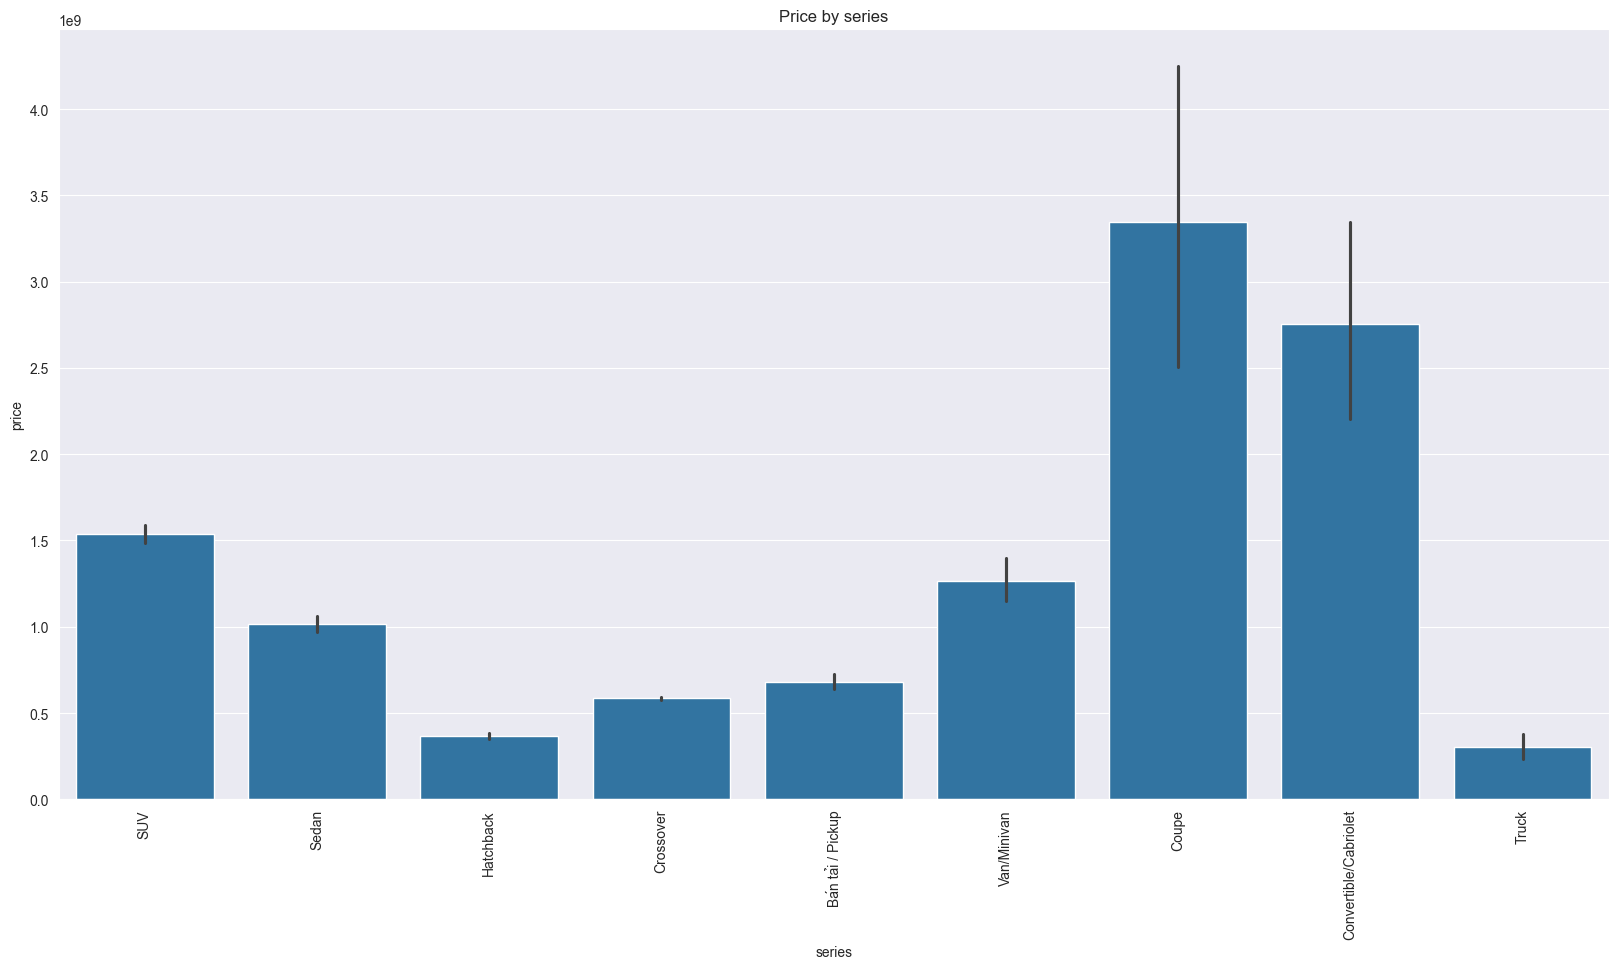

In [98]:
plt.figure(figsize=(20, 10))
sns.barplot(x='series', y='price', data=df)
plt.title('Price by series')
plt.xticks(rotation=90)
plt.show()

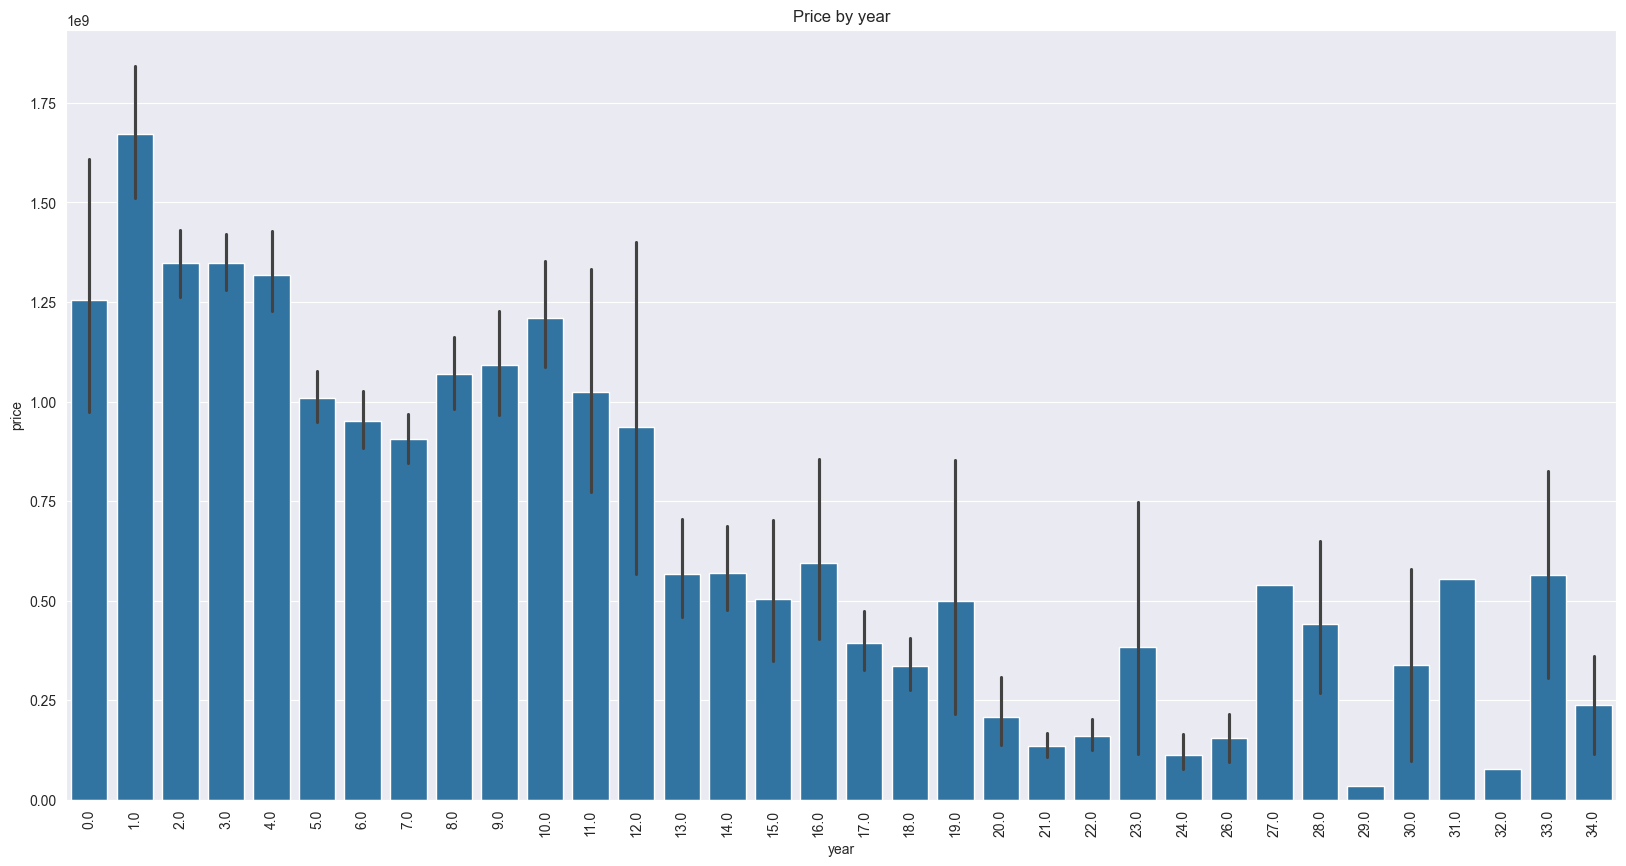

In [99]:
plt.figure(figsize=(20, 10))
#đổi năm sản xuất thành tuổi xe
df['year'] = 2024 - df['year']
sns.barplot(x='year', y='price', data=df)
plt.title('Price by year')
plt.xticks(rotation=90)
plt.show()

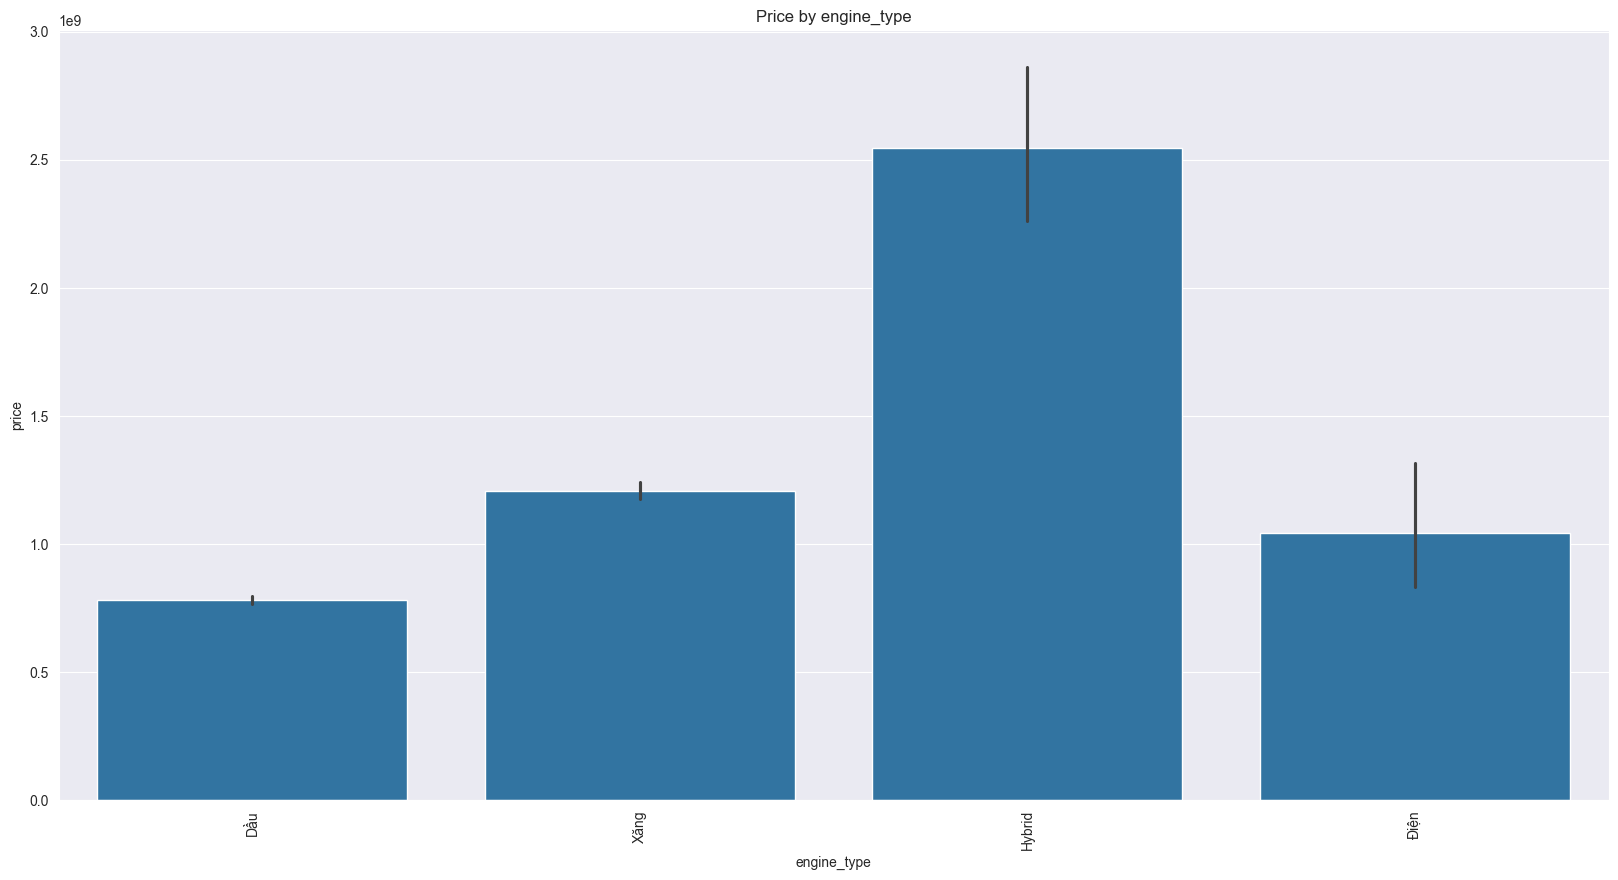

In [100]:
plt.figure(figsize=(20, 10))
sns.barplot(x='engine_type', y='price', data=df)
plt.title('Price by engine_type')
plt.xticks(rotation=90)
plt.show()


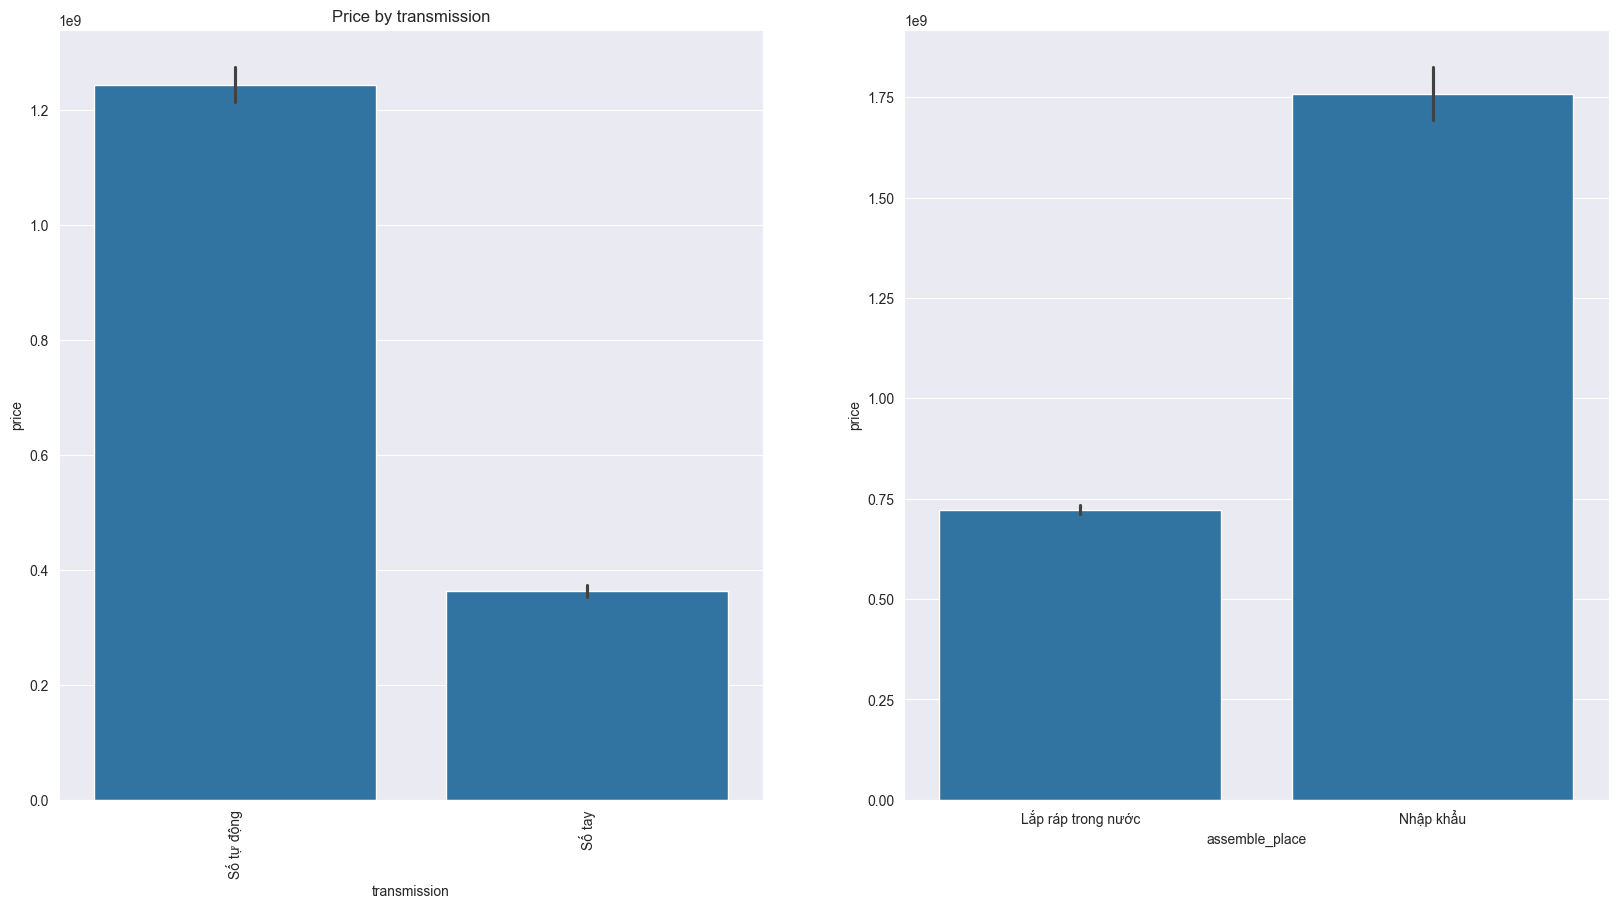

In [101]:
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
sns.barplot(x='transmission', y='price', data=df)
plt.title('Price by transmission')
plt.xticks(rotation=90)
plt.subplot(1, 2, 2)
sns.barplot(x='assemble_place', y='price', data=df)
plt.show()

# Tìm hiểu về mối liên hệ giữa các thuộc tính với nhau

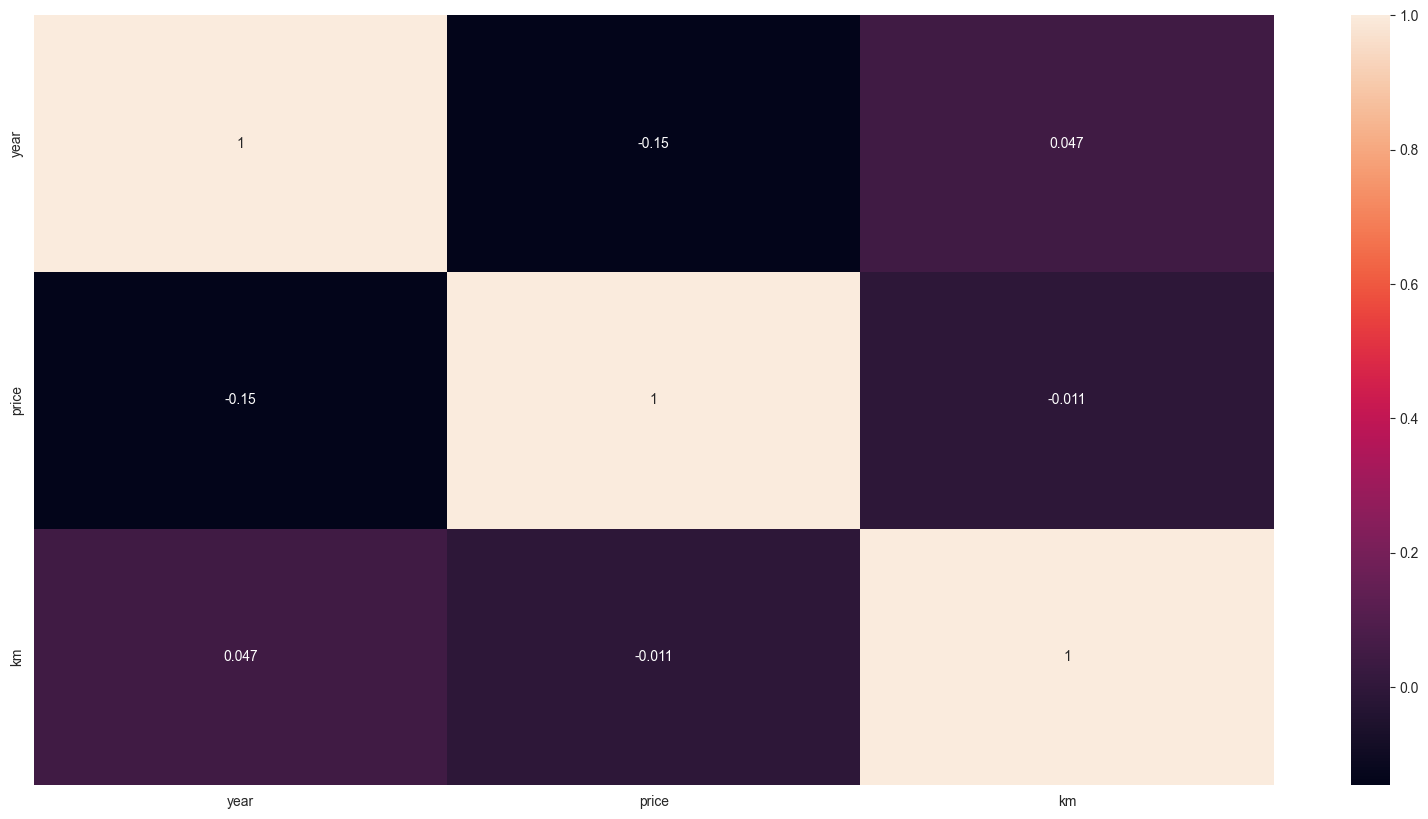

In [102]:
#vẽ biểu đồ nhiệt giữa price và các thuộc tính trừ model
plt.figure(figsize=(20, 10))
numeric_cols = df.select_dtypes(include=['float64', 'int64'])
sns.heatmap(numeric_cols.corr(), annot=True)
plt.show()

# Mã hóa các cột dạng nhãn thành dạng số để có thể sử dụng cho mô hình học máy

Cột assemble_place chỉ có 2 giá trị là 'Lắp ráp trong nước' và 'Nhập khẩu', ta sẽ mã hóa thành 0 và 1

In [103]:
df['assemble_place'] = df['assemble_place'].map({'Lắp ráp trong nước': 0, 'Nhập khẩu': 1})

In [104]:
df['transmission'] = df['transmission'].map({'Số tự động': 0, 'Số tay': 1})

In [105]:
df['assemble_place'].value_counts()

assemble_place
0    7046
1    5149
Name: count, dtype: int64

Cột brand sẽ được mã hóa bằng phương pháp One-hot encoding

In [43]:
# one_hot = OneHotEncoder()
# one_hot.fit(df[['brand_segment']])
# one_hot_brand = pd.get_dummies(df['brand_segment'], prefix='brand_segment')
# df = pd.concat([df, one_hot_brand], axis=1)
# df.drop('brand_segment', axis=1, inplace=True)
# df.head()

,car_name,year,price,assemble_place,series,km,engine_type,transmission,url,model,brand_segment_LOWEND,brand_segment_LUXURY,brand_segment_PREMIUM,brand_segment_VOLUME
0,Kia Sorento Signature 2.2 AT AWD,4.0,8.990000e+08,0,SUV,60000,Dầu,0,https://bonbanh.com/xe-kia-sorento-signature-2...,Sorento Signature 2.2 AT AWD,True,False,False,False
2,Kia Sorento GATH,6.0,5.680000e+08,0,SUV,80000,Xăng,0,https://bonbanh.com/xe-kia-sorento-gath-2018-5...,Sorento GATH,True,False,False,False
4,Mazda CX8 Premium AWD,2.0,9.290000e+08,0,SUV,50000,Xăng,0,https://bonbanh.com/xe-mazda-cx8-premium-awd-2...,CX8 Premium AWD,False,False,False,True
6,Nissan Almera 1.0 MT,2.0,3.690000e+08,1,Sedan,25000,Xăng,1,https://bonbanh.com/xe-nissan-almera-1.0-mt-20...,Almera 1.0 MT,True,False,False,False
7,Bentley Mulsanne 6.75 V8,13.0,4.900000e+09,1,Sedan,80000,Xăng,0,https://bonbanh.com/xe-bentley-mulsanne-6.75-v...,Mulsanne 6.75 V8,False,True,False,False


In [ ]:
#cột brand được mã hóa bằng TargetEncoder

In [108]:
target_encoder = ce.TargetEncoder()
df['brand'] = target_encoder.fit_transform(df['brand'], df['price'])


In [109]:
df.head()

,car_name,year,price,assemble_place,series,km,engine_type,transmission,url,brand,model
0,Kia Sorento Signature 2.2 AT AWD,4.0,8.990000e+08,0,SUV,60000,Dầu,0,https://bonbanh.com/xe-kia-sorento-signature-2...,5.950712e+08,Sorento Signature 2.2 AT AWD
2,Kia Sorento GATH,6.0,5.680000e+08,0,SUV,80000,Xăng,0,https://bonbanh.com/xe-kia-sorento-gath-2018-5...,5.950712e+08,Sorento GATH
4,Mazda CX8 Premium AWD,2.0,9.290000e+08,0,SUV,50000,Xăng,0,https://bonbanh.com/xe-mazda-cx8-premium-awd-2...,6.160559e+08,CX8 Premium AWD
6,Nissan Almera 1.0 MT,2.0,3.690000e+08,1,Sedan,25000,Xăng,1,https://bonbanh.com/xe-nissan-almera-1.0-mt-20...,4.602449e+08,Almera 1.0 MT
7,Bentley Mulsanne 6.75 V8,13.0,4.900000e+09,1,Sedan,80000,Xăng,0,https://bonbanh.com/xe-bentley-mulsanne-6.75-v...,4.286454e+09,Mulsanne 6.75 V8


Cột series sẽ được mã hóa bằng phương pháp One-hot encoding

In [110]:
one_hot = OneHotEncoder()
one_hot.fit(df[['series']])
one_hot_series = pd.get_dummies(df['series'], prefix='series')
df = pd.concat([df, one_hot_series], axis=1)

Cột engine_type sẽ được mã hóa bằng phương pháp One-hot encoding

In [45]:
df.head()

,car_name,year,price,assemble_place,series,km,engine_type,transmission,url,model,...,brand_segment_VOLUME,series_Bán tải / Pickup,series_Convertible/Cabriolet,series_Coupe,series_Crossover,series_Hatchback,series_SUV,series_Sedan,series_Truck,series_Van/Minivan
0,Kia Sorento Signature 2.2 AT AWD,4.0,8.990000e+08,0,SUV,60000,Dầu,0,https://bonbanh.com/xe-kia-sorento-signature-2...,Sorento Signature 2.2 AT AWD,...,False,False,False,False,False,False,True,False,False,False
2,Kia Sorento GATH,6.0,5.680000e+08,0,SUV,80000,Xăng,0,https://bonbanh.com/xe-kia-sorento-gath-2018-5...,Sorento GATH,...,False,False,False,False,False,False,True,False,False,False
4,Mazda CX8 Premium AWD,2.0,9.290000e+08,0,SUV,50000,Xăng,0,https://bonbanh.com/xe-mazda-cx8-premium-awd-2...,CX8 Premium AWD,...,True,False,False,False,False,False,True,False,False,False
6,Nissan Almera 1.0 MT,2.0,3.690000e+08,1,Sedan,25000,Xăng,1,https://bonbanh.com/xe-nissan-almera-1.0-mt-20...,Almera 1.0 MT,...,False,False,False,False,False,False,False,True,False,False
7,Bentley Mulsanne 6.75 V8,13.0,4.900000e+09,1,Sedan,80000,Xăng,0,https://bonbanh.com/xe-bentley-mulsanne-6.75-v...,Mulsanne 6.75 V8,...,False,False,False,False,False,False,False,True,False,False


In [111]:
one_hot = OneHotEncoder()
one_hot.fit(df[['engine_type']])
one_hot_engine_type = pd.get_dummies(df['engine_type'], prefix='engine_type')
df = pd.concat([df, one_hot_engine_type], axis=1)

In [47]:
df.head()

,car_name,year,price,assemble_place,series,km,engine_type,transmission,url,model,...,series_Crossover,series_Hatchback,series_SUV,series_Sedan,series_Truck,series_Van/Minivan,engine_type_Dầu,engine_type_Hybrid,engine_type_Xăng,engine_type_Điện
0,Kia Sorento Signature 2.2 AT AWD,4.0,8.990000e+08,0,SUV,60000,Dầu,0,https://bonbanh.com/xe-kia-sorento-signature-2...,Sorento Signature 2.2 AT AWD,...,False,False,True,False,False,False,True,False,False,False
2,Kia Sorento GATH,6.0,5.680000e+08,0,SUV,80000,Xăng,0,https://bonbanh.com/xe-kia-sorento-gath-2018-5...,Sorento GATH,...,False,False,True,False,False,False,False,False,True,False
4,Mazda CX8 Premium AWD,2.0,9.290000e+08,0,SUV,50000,Xăng,0,https://bonbanh.com/xe-mazda-cx8-premium-awd-2...,CX8 Premium AWD,...,False,False,True,False,False,False,False,False,True,False
6,Nissan Almera 1.0 MT,2.0,3.690000e+08,1,Sedan,25000,Xăng,1,https://bonbanh.com/xe-nissan-almera-1.0-mt-20...,Almera 1.0 MT,...,False,False,False,True,False,False,False,False,True,False
7,Bentley Mulsanne 6.75 V8,13.0,4.900000e+09,1,Sedan,80000,Xăng,0,https://bonbanh.com/xe-bentley-mulsanne-6.75-v...,Mulsanne 6.75 V8,...,False,False,False,True,False,False,False,False,True,False


In [112]:
save_df = copy.deepcopy(df)

In [113]:
save_df.head()

,car_name,year,price,assemble_place,series,km,engine_type,transmission,url,brand,...,series_Crossover,series_Hatchback,series_SUV,series_Sedan,series_Truck,series_Van/Minivan,engine_type_Dầu,engine_type_Hybrid,engine_type_Xăng,engine_type_Điện
0,Kia Sorento Signature 2.2 AT AWD,4.0,8.990000e+08,0,SUV,60000,Dầu,0,https://bonbanh.com/xe-kia-sorento-signature-2...,5.950712e+08,...,False,False,True,False,False,False,True,False,False,False
2,Kia Sorento GATH,6.0,5.680000e+08,0,SUV,80000,Xăng,0,https://bonbanh.com/xe-kia-sorento-gath-2018-5...,5.950712e+08,...,False,False,True,False,False,False,False,False,True,False
4,Mazda CX8 Premium AWD,2.0,9.290000e+08,0,SUV,50000,Xăng,0,https://bonbanh.com/xe-mazda-cx8-premium-awd-2...,6.160559e+08,...,False,False,True,False,False,False,False,False,True,False
6,Nissan Almera 1.0 MT,2.0,3.690000e+08,1,Sedan,25000,Xăng,1,https://bonbanh.com/xe-nissan-almera-1.0-mt-20...,4.602449e+08,...,False,False,False,True,False,False,False,False,True,False
7,Bentley Mulsanne 6.75 V8,13.0,4.900000e+09,1,Sedan,80000,Xăng,0,https://bonbanh.com/xe-bentley-mulsanne-6.75-v...,4.286454e+09,...,False,False,False,True,False,False,False,False,True,False


# Sử dụng Standardization để chuẩn hóa dữ liệu

In [114]:
scaler = StandardScaler()
df=save_df.copy()
#fit year và driven kms
scaler.fit(df[['km']])
df[['km']] = scaler.transform(df[['km']])

In [115]:
df['km'].describe()

count    1.219500e+04
mean     1.165302e-18
std      1.000041e+00
min     -3.459210e-02
25%     -2.481958e-02
50%     -1.749019e-02
75%     -7.717668e-03
max      9.070989e+01
Name: km, dtype: float64

# Sử dụng hồi quy tuyến tính để dự đoán giá xe

In [52]:
df.head()

,car_name,year,price,assemble_place,series,km,engine_type,transmission,url,model,...,series_Crossover,series_Hatchback,series_SUV,series_Sedan,series_Truck,series_Van/Minivan,engine_type_Dầu,engine_type_Hybrid,engine_type_Xăng,engine_type_Điện
0,Kia Sorento Signature 2.2 AT AWD,4.0,8.990000e+08,0,SUV,-0.014000,Dầu,0,https://bonbanh.com/xe-kia-sorento-signature-2...,Sorento Signature 2.2 AT AWD,...,False,False,True,False,False,False,True,False,False,False
2,Kia Sorento GATH,6.0,5.680000e+08,0,SUV,-0.007020,Xăng,0,https://bonbanh.com/xe-kia-sorento-gath-2018-5...,Sorento GATH,...,False,False,True,False,False,False,False,False,True,False
4,Mazda CX8 Premium AWD,2.0,9.290000e+08,0,SUV,-0.017490,Xăng,0,https://bonbanh.com/xe-mazda-cx8-premium-awd-2...,CX8 Premium AWD,...,False,False,True,False,False,False,False,False,True,False
6,Nissan Almera 1.0 MT,2.0,3.690000e+08,1,Sedan,-0.026216,Xăng,1,https://bonbanh.com/xe-nissan-almera-1.0-mt-20...,Almera 1.0 MT,...,False,False,False,True,False,False,False,False,True,False
7,Bentley Mulsanne 6.75 V8,13.0,4.900000e+09,1,Sedan,-0.007020,Xăng,0,https://bonbanh.com/xe-bentley-mulsanne-6.75-v...,Mulsanne 6.75 V8,...,False,False,False,True,False,False,False,False,True,False


In [53]:
print(df.columns)

Index(['car_name', 'year', 'price', 'assemble_place', 'series', 'km',
       'engine_type', 'transmission', 'url', 'model', 'brand_segment_LOWEND',
       'brand_segment_LUXURY', 'brand_segment_PREMIUM', 'brand_segment_VOLUME',
       'series_Bán tải / Pickup', 'series_Convertible/Cabriolet',
       'series_Coupe', 'series_Crossover', 'series_Hatchback', 'series_SUV',
       'series_Sedan', 'series_Truck', 'series_Van/Minivan', 'engine_type_Dầu',
       'engine_type_Hybrid', 'engine_type_Xăng', 'engine_type_Điện'],
      dtype='object')


In [116]:
df.drop(['model', 'series', 'engine_type','car_name','url'], axis=1, inplace=True)

In [117]:
df.head()

,year,price,assemble_place,km,transmission,brand,series_Bán tải / Pickup,series_Convertible/Cabriolet,series_Coupe,series_Crossover,series_Hatchback,series_SUV,series_Sedan,series_Truck,series_Van/Minivan,engine_type_Dầu,engine_type_Hybrid,engine_type_Xăng,engine_type_Điện
0,4.0,8.990000e+08,0,-0.014000,0,5.950712e+08,False,False,False,False,False,True,False,False,False,True,False,False,False
2,6.0,5.680000e+08,0,-0.007020,0,5.950712e+08,False,False,False,False,False,True,False,False,False,False,False,True,False
4,2.0,9.290000e+08,0,-0.017490,0,6.160559e+08,False,False,False,False,False,True,False,False,False,False,False,True,False
6,2.0,3.690000e+08,1,-0.026216,1,4.602449e+08,False,False,False,False,False,False,True,False,False,False,False,True,False
7,13.0,4.900000e+09,1,-0.007020,0,4.286454e+09,False,False,False,False,False,False,True,False,False,False,False,True,False


In [56]:
df.dropna(inplace=True)

In [133]:
model = LinearRegression()
X = df.drop('price', axis=1)
y = df['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(model.score(X_test, y_test))


0.5333186811644978


In [58]:
df.head()

,year,price,assemble_place,km,transmission,brand_segment_LOWEND,brand_segment_LUXURY,brand_segment_PREMIUM,brand_segment_VOLUME,series_Bán tải / Pickup,...,series_Crossover,series_Hatchback,series_SUV,series_Sedan,series_Truck,series_Van/Minivan,engine_type_Dầu,engine_type_Hybrid,engine_type_Xăng,engine_type_Điện
0,4.0,8.990000e+08,0,-0.014000,0,True,False,False,False,False,...,False,False,True,False,False,False,True,False,False,False
2,6.0,5.680000e+08,0,-0.007020,0,True,False,False,False,False,...,False,False,True,False,False,False,False,False,True,False
4,2.0,9.290000e+08,0,-0.017490,0,False,False,False,True,False,...,False,False,True,False,False,False,False,False,True,False
6,2.0,3.690000e+08,1,-0.026216,1,True,False,False,False,False,...,False,False,False,True,False,False,False,False,True,False
7,13.0,4.900000e+09,1,-0.007020,0,False,True,False,False,False,...,False,False,False,True,False,False,False,False,True,False


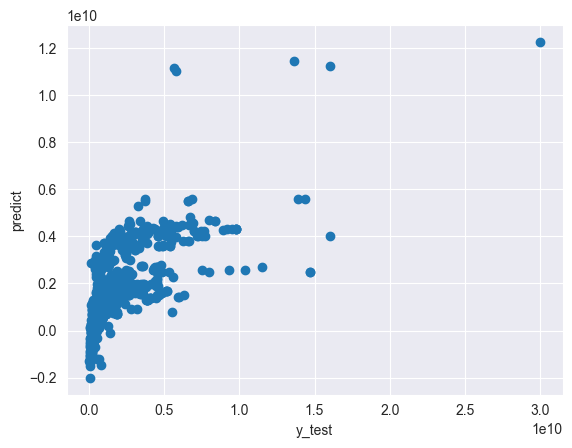

In [119]:
predict = model.predict(X_test)
plt.scatter(y_test, predict)
plt.xlabel('y_test')
plt.ylabel('predict')
plt.show()

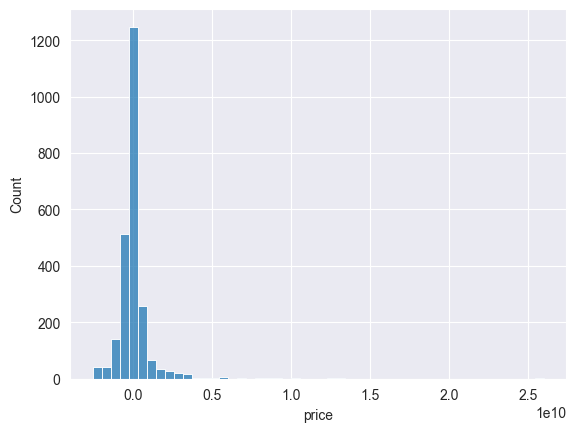

In [60]:
sns.histplot((y_test-predict),bins=50);


In [61]:


print('MAE:', metrics.mean_absolute_error(y_test, predict))
print('MSE:', metrics.mean_squared_error(y_test, predict))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predict)))


MAE: 573689421.8739787
MSE: 1.482859259153998e+18
RMSE: 1217727087.304047


In [62]:
# thử sử dụng random forest

In [120]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=100)
rf.get_params()


{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [122]:
from sklearn.model_selection import KFold, RandomizedSearchCV

"""
+ Search over space of hyperparameters to find acceptable ones
+ Two search methods implemented by scikit-learn: GridSearch and RandomSearch
+ RandomSearch is faster in case we search over large space (too many combinations of hyperparameters)
"""

rf_hyperparams = {
    'n_estimators': [200, 300, 400, 500],
    'max_depth': [None, 10, 50, 90, 110],
    'max_features': ['sqrt'],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

rf_randomized_search = RandomizedSearchCV(
    estimator = rf,
    param_distributions = rf_hyperparams,
    n_iter = 10,
    cv=KFold(n_splits=10, shuffle=True, random_state=42),
    verbose=2,
    random_state=42,
    n_jobs = -1
)



In [123]:
rf_randomized_search.fit(X_train, y_train)


Fitting 10 folds for each of 10 candidates, totalling 100 fits


RandomizedSearchCV(cv=KFold(n_splits=10, random_state=42, shuffle=True),
                   estimator=RandomForestRegressor(), n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [None, 10, 50, 90, 110],
                                        'max_features': ['sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 300, 400, 500]},
                   random_state=42, verbose=2)

In [124]:
rf_randomized_search.score(X_test, y_test)

0.8240194876982042

Feature ranking:
year: 8.876903553726152e-05
assemble_place: 0.00011135372324852206
km: 0.001284903528910872
transmission: 0.0034971540912132333
brand: 0.0038133175354108885
series_Bán tải / Pickup: 0.005523034356081265
series_Convertible/Cabriolet: 0.0055419291687774964
series_Coupe: 0.006571679570564624
series_Crossover: 0.008251450691619018
series_Hatchback: 0.009023244701816317
series_SUV: 0.009131792431153614
series_Sedan: 0.010623601180807811
series_Truck: 0.012203944491022061
series_Van/Minivan: 0.02485706808848919
engine_type_Dầu: 0.09366358612256165
engine_type_Hybrid: 0.10091728939278923
engine_type_Xăng: 0.18083754716038225
engine_type_Điện: 0.5240583347296148


In [125]:
print('MAE:', metrics.mean_absolute_error(y_test, rf_randomized_search.predict(X_test)))
print('MSE:', metrics.mean_squared_error(y_test, rf_randomized_search.predict(X_test)))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, rf_randomized_search.predict(X_test))))


MAE: 245776520.87919354
MSE: 4.556200739024877e+17
RMSE: 674996351.0290169


In [126]:
# predict thử cho xe có url:https://bonbanh.com/xe-toyota-prado-vx-2.7l-2022-4925201 trong tập data set
car =save_df[save_df['url'] == 'https://bonbanh.com/xe-peugeot-3008-al-2022-5577577']
car.drop(['model', 'series', 'engine_type','car_name','url','price'], axis=1, inplace=True)
print('price of car is: ',rf_randomized_search.predict(car)[0])


price of car is:  683531564.8981954


C:\Users\NamNV\AppData\Local\Temp\ipykernel_2344\3925268102.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  car.drop(['model', 'series', 'engine_type','car_name','url','price'], axis=1, inplace=True)


In [131]:
lgbm = lgb.LGBMRegressor()
lgbm.fit(X_train, y_train)

y_pred = lgbm.predict(X_test)
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))
print('MSE:', metrics.mean_squared_error(y_test, y_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
#score
print("score: ",lgbm.score(X_test,y_test))

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000754 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 347
[LightGBM] [Info] Number of data points in the train set: 9756, number of used features: 18
[LightGBM] [Info] Start training from score 1159885304.357524
MAE: 305750530.0458264
MSE: 5.6274373273302995e+17
RMSE: 750162470.8908263
score:  0.7826436189855446


In [ ]:
from sklearn.linear_model import Ridge
rg = Ridge(alpha=1.0)
rg.fit(X_train, y_train)
rg.score(X_test, y_test)


In [ ]:
#Support Vector Regression

In [ ]:
from sklearn.svm import SVR

svr = SVR(kernel='rbf')
svr.fit(X_train, y_train)
svr.score(X_test, y_test)

In [ ]:
df.head()

In [ ]:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV

# Định nghĩa lưới các tham số
param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (50,50)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
}

mlp = MLPRegressor(max_iter=500)

clf = GridSearchCV(mlp, param_grid, cv=5, scoring='neg_mean_squared_error')

clf.fit(X_train, y_train)

print(f'Best parameters: {clf.best_params_}')


In [ ]:
clf.score(X_test, y_test)